In [ ]:
import numpy as np, torch, time, os
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_all, load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 2: C-tube Mold for Casting

In [4]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig2_casting/directrix_Q.obj"))
K = cps_ref.shape[0]
M = (K - 1) * 5 + 1

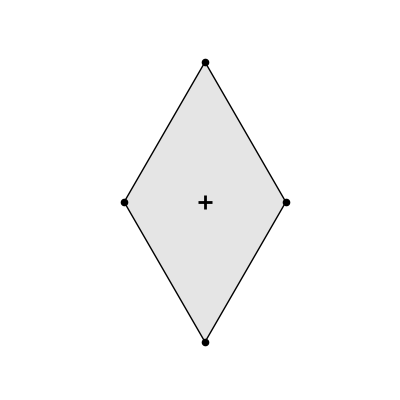

In [5]:
# Generatrix: rhombus
N = 4
tube_radius = 0.8

generatrix_2d = torch.zeros(size=(N, 2))
generatrix_2d[0, 0] =   tube_radius * 1.0
generatrix_2d[1, 1] =   tube_radius * torch.sqrt(torch.tensor(3.0))
generatrix_2d[2, 0] = - tube_radius * 1.0
generatrix_2d[3, 1] = - tube_radius * torch.sqrt(torch.tensor(3.0))

fig, ax = plot_generatrix(generatrix_2d)

In [6]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

tube = CTube(directrix, generatrix)

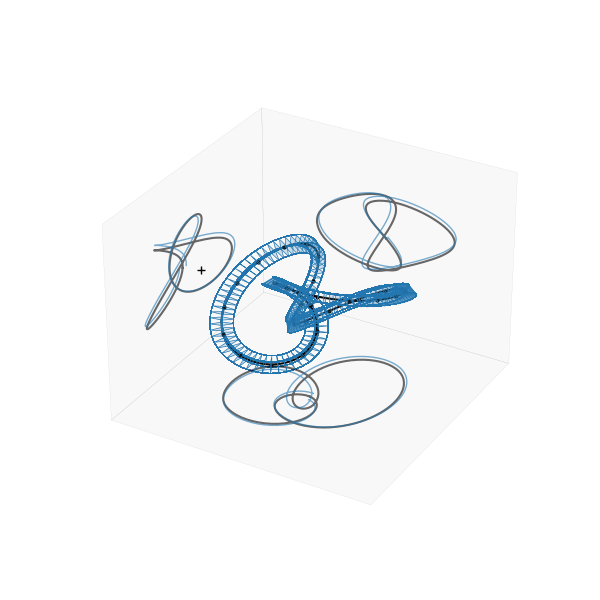

In [7]:
fig, ax = tube.plot_3d()

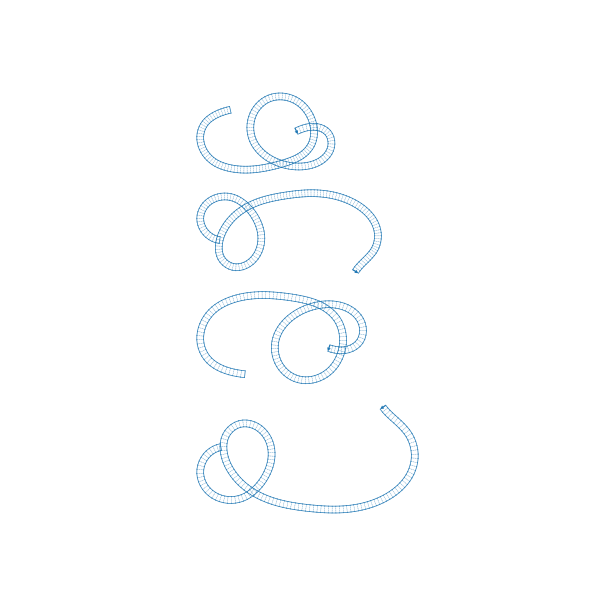

In [8]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [9]:
# Load target cross-section radii from file
target_cross_section_radii = torch.tensor(
    np.loadtxt(os.path.join(paths["data"], "fig2_casting/target_cross_section_radii.txt")), 
    dtype=TORCH_DTYPE
)

In [10]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_section_radius': 1.6e1 / generatrix.aabb_diagonal_length() ** 2,
    'smooth_plane_normal_diffs': 1e-1,
    'smooth_apex_loc_func': 1e2,
    'join_ends': 1e1 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'target_cross_section_radii': target_cross_section_radii,
    'join_ends_pairings': get_pairings_all(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(True)
opt_prob.activate_plane_normals(True)

In [11]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_section_radius       : 1.7966958913
smooth_plane_normal_diffs               : 0.0000351239
smooth_apex_loc_func                    : 0.0000000000
join_ends                               : 0.1658187554
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000000000


tensor(1.9625)

In [12]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [13]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          583     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96255D+00    |proj g|=  2.53494D+00

At iterate    1    f=  1.40891D+00    |proj g|=  1.48014D+00

At iterate    2    f=  1.19036D+00    |proj g|=  2.10340D+00


 This problem is unconstrained.



At iterate    3    f=  8.86389D-01    |proj g|=  2.93189D+00

At iterate    4    f=  6.46442D-01    |proj g|=  5.95799D-01

At iterate    5    f=  5.87227D-01    |proj g|=  7.04969D-01

At iterate    6    f=  4.58166D-01    |proj g|=  8.15218D-01

At iterate    7    f=  2.34567D-01    |proj g|=  8.33828D-01

At iterate    8    f=  1.91099D-01    |proj g|=  2.39897D-01

At iterate    9    f=  1.78511D-01    |proj g|=  1.51358D-01

At iterate   10    f=  1.62945D-01    |proj g|=  2.46818D-01

At iterate   11    f=  1.54134D-01    |proj g|=  1.41004D-01

At iterate   12    f=  1.49172D-01    |proj g|=  1.15912D-01

At iterate   13    f=  1.34581D-01    |proj g|=  2.17823D-01

At iterate   14    f=  1.25345D-01    |proj g|=  2.20747D-01

At iterate   15    f=  1.22077D-01    |proj g|=  1.54225D-01

At iterate   16    f=  1.14981D-01    |proj g|=  1.55544D-01

At iterate   17    f=  1.03547D-01    |proj g|=  1.87263D-01

At iterate   18    f=  6.71639D-02    |proj g|=  2.81955D-01

At iter

In [25]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_section_radius       : 0.0000020004
smooth_plane_normal_diffs               : 0.0000336186
smooth_apex_loc_func                    : 0.0000090024
join_ends                               : 0.0000001458
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000001473


tensor(4.4914e-05)

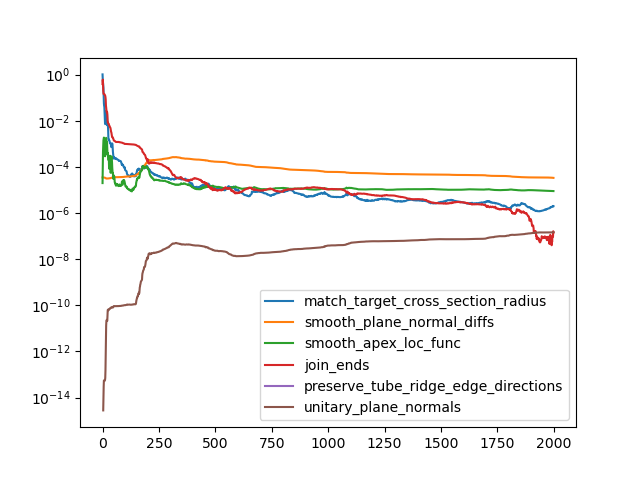

In [26]:
fig, ax = opt_prob.plot_objective_history()

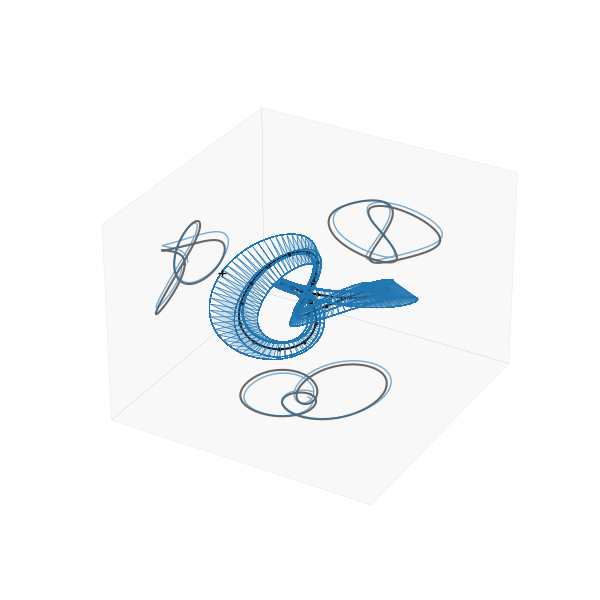

In [27]:
fig, ax = opt_prob.plot_3d()

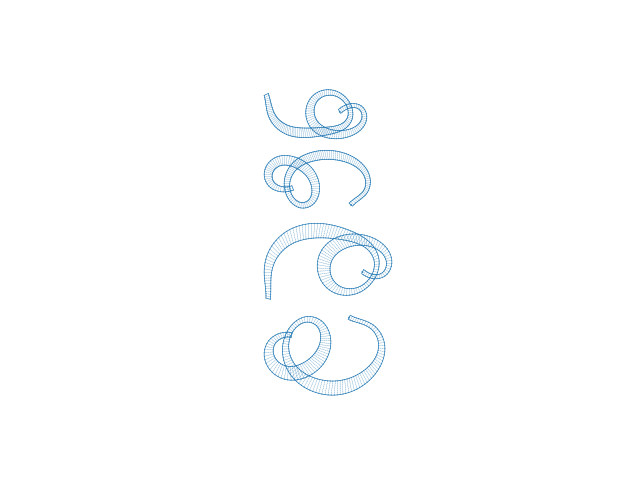

In [28]:
fig, ax = opt_prob.plot_unrolled_strips()

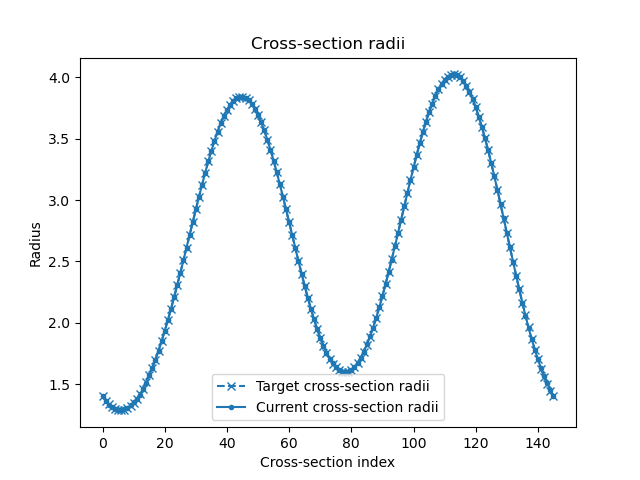

In [29]:
fig, ax = opt_prob.plot_cross_section_radii()